# This notebook tries to augment data using forest diffusion on datasets

#### Vanilla ForestDiffusion on diabetes dataset

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, f1_score

# Step 1: Load the CSV file
#file_path = 'creditcard.csv'  # Update this path to your local CSV file
dataset = 'creditcard_sampled'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)

# Step 2: Inspect the data and check for class imbalance
# Assuming the last column is the label, and the rest are features
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values  # Labels (binary classification)

# Check and print the original class distribution
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# # Step 3: Plot the original imbalanced data (first two features for visualization)
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', label='Original Data', s=1)
# plt.title('Original Imbalanced Data')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.show()

# Separate the minority class
X_minority = X[y == 1]
y_minority = y[y==1]
# Identify integer columns
int_columns = data.select_dtypes(include=['int']).columns
int_indexes = []
for col in int_columns:
    col_index = data.columns.get_loc(col)
    int_indexes.append(col_index)


Class distribution before augmentation: {0: 4000, 1: 50}


In [2]:
y_minority.shape
# y_minority1=np.expand_dims(y_minority, axis=1)
print(X_minority.shape)
print(y_minority.shape)

(268, 8)
(268,)


In [2]:
import pandas as pd
# Step 4: Upsample the minority class using ForestDiffusionModel
forest_model = ForestDiffusionModel(X_minority, label_y=y_minority, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1)
Xy_minority_fake = forest_model.generate(batch_size=100 )  # Adjust the batch size to create a balanced dataset


In [3]:
# Add generated samples to the main imbalanced dataset
X_minority_fake = Xy_minority_fake[:, :-1]   # Features
y_minority_fake = Xy_minority_fake[:, -1] # Labels (binary classification)
X_balanced = np.concatenate((X, X_minority_fake), axis=0)
y_balanced = np.concatenate((y, y_minority_fake), axis=0)

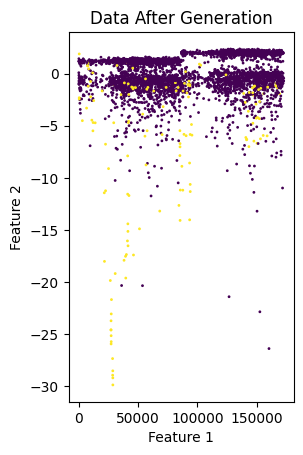

Class distribution after augmentation: {0.0: 4000, 1.0: 150}
Precision score (original data): 0.8667
Precision score (generated data): 0.8824
Recall score (original data): 0.7647
Recall score (generated data): 0.8824
F1 score (original data): 0.8125
F1 score (generated data): 0.8824
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1198
           1       0.87      0.76      0.81        17

    accuracy                           1.00      1215
   macro avg       0.93      0.88      0.90      1215
weighted avg       0.99      1.00      0.99      1215

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1198
           1       0.88      0.88      0.88        17

    accuracy                           1.00      1215
   macro avg       0.94      0.94      0.94      1215
weighted avg       1.00      1.00   

In [4]:
# Step 5: Plot the generated data (first two features for visualization)
plt.subplot(1, 2, 2)
plt.scatter(X_balanced[:, 0], X_balanced[:, 1], c=y_balanced, cmap='viridis', label='Generated Data', s=1)
plt.title('Data After Generation')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Check and print the class distribution after augmentation
unique_bal, counts_bal = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique_bal, counts_bal))
print(f"Class distribution after augmentation: {class_dist_after}")

# Step 6: Split the dataset into training and test sets (original and balanced)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Step 7: Train a simple classifier on both original and generated datasets
clf_orig = RandomForestClassifier(random_state=42)
clf_orig.fit(X_train_orig, y_train_orig)

clf_bal = RandomForestClassifier(random_state=42)
clf_bal.fit(X_train_bal, y_train_bal)

# Step 8: Predict and calculate recall and F1 scores
y_pred_orig = clf_orig.predict(X_test_orig)
y_pred_bal = clf_bal.predict(X_test_orig)

prec_orig = precision_score(y_test_orig, y_pred_orig)
prec_bal = precision_score(y_test_orig, y_pred_bal)


recall_orig = recall_score(y_test_orig, y_pred_orig)
recalls_bal = recall_score(y_test_orig, y_pred_bal)

f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_orig, y_pred_bal)

# Step 9: Print the performance metrics
print(f"Precision score (original data): {prec_orig:.4f}")
print(f"Precision score (generated data): {prec_bal:.4f}")
print(f"Recall score (original data): {recall_orig:.4f}")
print(f"Recall score (generated data): {recalls_bal:.4f}")
print(f"F1 score (original data): {f1_orig:.4f}")
print(f"F1 score (generated data): {f1_bal:.4f}")
print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))

# Step 10: Print the number of fake samples generated
print(f"Number of fake samples generated: {len(X_minority_fake)}")